<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/2019%20Fastai%20Deep%20Learning/2019_Deep_Learning_7_MNIST_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Video](https://youtu.be/nWpdkZE2_cc) / [Course Forum](https://forums.fast.ai/t/lesson-7-official-resources/32553)

Welcome to lesson 7! The last lesson of part 1. This will be a pretty intense lesson. Don't let that bother you because partly what I want to do is to give you enough things to think about to keep you busy until part 2. In fact, some of the things we cover today, I'm not going to tell you about some of the details. I'll just point out a few things. I'll say like okay that we're not talking about yet, that we're not talking about yet. Then come back in part 2 to get the details on some of these extra pieces. So today will be a lot of material pretty quickly. You might require a few viewings to fully understand at all or a few experiments and so forth. That's kind of intentional. I'm trying to give you stuff to to keep you amused for a couple of months.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/1.png?raw=true)

I wanted to start by showing some cool work done by a couple of students; Reshama and Nidhin who have developed an Android and an iOS app, so check out [Reshma's post on the forum] about that because they have a demonstration of how to create both Android and iOS apps that are actually on the Play Store and on the Apple App Store, so that's pretty cool. First ones I know of that are on the App Store's that are using fast.ai. Let me also say a huge thank you to Reshama for all of the work she does both for the fast.ai community and the machine learning community more generally, and also the Women in Machine Learning community in particular. She does a lot of fantastic work including providing lots of fantastic documentation and tutorials and community organizing and so many other things. So thank you, Reshama and congrats on getting this app out there.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# MNIST CNN [2:04](https://youtu.be/nWpdkZE2_cc?t=124)

We have lots of lesson 7 notebooks today, as you see. The first notebook we're going to look at is [lesson7-resnet-mnist.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-resnet-mnist.ipynb). What I want to do is look at some of the stuff we started talking about last week around convolutions and convolutional neural networks, and start building on top of them to create a fairly modern deep learning architecture largely from scratch. When I say from scratch, I'm not going to re-implement things we already know how to implement, but use the pre-existing PyTorch bits of those. So we're going to use the MNIST dataset. URLs.MNIST has the whole MNIST dataset, often we've done stuff with a subset of it.

In [0]:
from fastai.vision import *

In [0]:
path = untar_data(URLs.MNIST)

In [18]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

## More understanding Datablock

In there, there's a training folder and a testing folder. As I read this in, I'm going to show some more details about pieces of the data blocks API, so that you see what's going on. Normally with the date blocks API, we've kind of said blah.blah.blah.blah.blah and done it all in one cell, but let's do it in one cell at a time.

In [0]:
il = ImageList.from_folder(path,convert_mode="L")

First thing you say is what kind of item list do you have. So in this case it's an item list of images. Then where are you getting the list of file names from. In this case, by looking in a folder recursively. That's where it's coming from.

You can pass in arguments that end up going to Pillow because Pillow (a.k.a. PIL) is the thing that actually opens that for us, and in this case these are black and white rather than RGB, so you have to use Pillow's **convert_mode='L'**. For more details refer to the python imaging library documentation to see what their convert modes are. But this one is going to be a grayscale which is what MNIST is.

In [20]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/training/2/20247.png')

So inside an item list is an **items** attribute, and the **items** attribute is kind of thing that you gave it. It's the thing that it's going to use to create your items. So in this case, the thing you gave it really is a list of file names. That's what it got from the folder.

In [0]:
defaults.cmap='binary'

When you show images, normally it shows them in RGB. In this case, we want to use a binary color map. In fast.ai, you can set a default color map. For more information about cmap and color maps, refer to the matplotlib documentation. And **defaults.cmap='binary'** world set the default color map for fast.ai.

In [22]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

Our image item list contains 70,000 items, and it's a bunch of images that are 1 by 28 by 28. Remember that PyTorch puts channel first, so they are one channel 28x28. **You might think why aren't there just 28 by 28 matrices rather than a 1 by 28 by 28 rank 3 tensor. It's just easier that way. All the Conv2d stuff and so forth works on rank 3 tensors, so you want to include that unit axis at the start, so fast.ai will do that for you even when it's reading one channel images**.

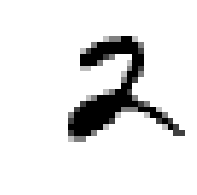

In [23]:
il[0].show()

The **.items** attribute contains the things that's read to build the image which in this case is the file name, but if you just index into an item list directly, you'll get the actual image object. The actual image object has a show method, and so there's the image.

In [0]:
sd = il.split_by_folder(train='training',valid='testing')

Once you've got an image item list, you then split it into training versus validation. You nearly always want validation. If you don't, you can actually use the **.no_split** method to create an empty validation set. You can't skip it entirely. You have to say how to split, and one of the options is **no_split**.

So remember, that's always the order. First create your item list, then decide how to split. In this case, we're going to do it based on folders. The validation folder for MNIST is called **testing**. In fast.ai parlance, we use the same kind of parlance that Kaggle does which is the training set is what you train on, the validation set has labels and you do it for testing that your models working. The test set doesn't have labels and you use it for doing inference, submitting to a competition, or sending it off to somebody who's held out those labels for vendor testing or whatever. So just because a folder in your data set is called **testing**, doesn't mean it's a test set. This one has labels, so it's a validation set.

If you want to do inference on lots of things at a time rather than one thing at a time, you want to use the **test=** in fast.ai to say this is stuff which has no labels and I'm just using for inference.

[6:54](https://youtu.be/nWpdkZE2_cc?t=414)



In [25]:
sd


ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

So my split data is a training set and a validation set, as you can see.

In [26]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/0')]

Inside the training set, there's a folder for each class.

In [0]:
ll = sd.label_from_folder()

Now we can take that split data and say label_from_folder.

So first you create the item list, then you split it, then you label it.

In [28]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,2,2,2,2
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
2,2,2,2,2
Path: /root/.fastai/data/mnist_png;

Test: None

You can see now we have an x and the y, and the y are category objects. Category object is just a class basically.

In [0]:
x,y = ll.train[0]

If you index into a label list such as ll.train as a label list, you will get back an independent variable and independent variable (i.e. x and y). In this case, the x will be an image object which I can show, and the y will be a category object which I can print:

2 torch.Size([1, 28, 28])


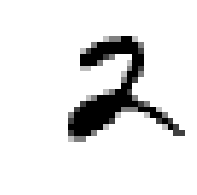

In [30]:
x.show()
print(y,x.shape)

That's the number 2 category, and there's the 2.

[7:56](https://youtu.be/nWpdkZE2_cc?t=476)

In [0]:
tfms = ([*rand_pad(padding=3,size=28,mode ='zeros')],[])

Next thing we can do is to add transforms. In this case, we're not going to use the normal **get_transforms** function because we're doing digit recognition and digit recognition, you wouldn't want to flip it left right. That would change the meaning of it. You wouldn't want to rotate it too much, that would change the meaning of it. Also because these images are so small, doing zooms and stuff is going to make them so fuzzy as to be unreadable. So normally, for small images of digits like this, you just add a bit of random padding. So I'll use the random padding function which actually returns two transforms; the bit that does the padding and the bit that does the random crop. So you have to use star`(*)` to say put both these transforms in this list.

In [0]:
ll = ll.transform(tfms)

Now we call transform. This empty array here is referring to the validation set transforms:

![alt text](https://github.com/hiromis/notes/raw/master/lesson7/3.png?raw=true)

So no transforms with the validation set.

Now we've got a transformed labeled list, we can pick a batch size and choose data bunch:

In [0]:
bs = 128

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

We can choose normalize. In this case, we're not using a pre-trained model, so there's no reason to use ImageNet stats here. **So if you call normalize like this without passing in stats, it will grab a batch of data at random and use that to decide what normalization stats to use**. That's a good idea if you're not using a pre-trained model.

In [0]:
x,y = data.train_ds[0]

2


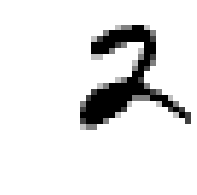

In [46]:
x.show()
print(y)

Okay, so we've got a data bunch and in that data bunch is a data set which we've seen already. But what is interesting is that the training data set now has data augmentation because we've got transforms. plot_multi is a fast.ai function that will plot the result of calling some function for each of this row by column grid. So in this case, my function is just grab the first image from the training set and because each time you grab something from the training set, it's going to load it from disk and it's going to transform it on the fly. People sometimes ask how many transformed versions of the image do you create and the answer is infinite. Each time we grab one thing from the data set, we do a random transform on the fly, so potentially every one will look a little bit different. So you can see here, if we plot the result of that lots of times, we get 8's in slightly different positions because we did random padding.

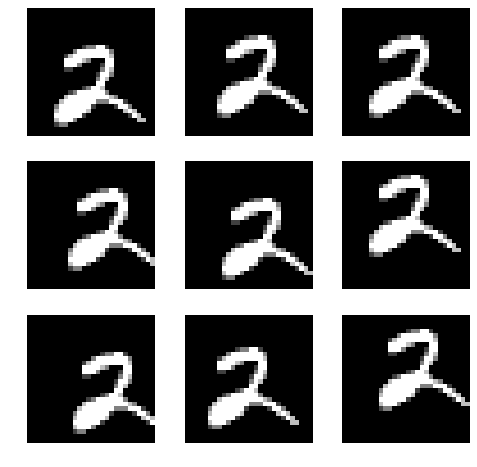

In [47]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax,cmap='gray')
plot_multi(_plot,3,3,figsize=(8,8))

[10:27](https://youtu.be/nWpdkZE2_cc?t=627)

You can always grab a batch of data then from the data bunch, because remember, data bunch has data loaders, and data loaders are things you grab a batch at a time. So you can then grab a X batch and a Y batch, look at their shape - batch size by channel by row by column:

In [48]:
xb,yb =data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

All fast.ai data bunches have a show_batch which will show you what's in it in some sensible way:

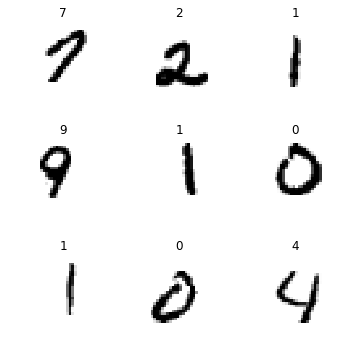

In [49]:
data.show_batch(rows=3,figsize=(5,5))

That was a quick walk through with a data block API stuff to grab our data.

## Basic CNN with batch norm : using only Pytorch [11:01](https://youtu.be/nWpdkZE2_cc?t=661) 

Let's start out creating a simple CNN. The input is 28 by 28. I like to define when I'm creating architectures a function which kind of does the things that I do again and again and again. I don't want to call it with the same arguments because I'll forget or I make a mistake. In this case, all of my convolution is going to be kernel size 3 stride 2 padding 1. So let's just create a simple function to do a conv with those parameters:

In [0]:
def conv(ni,nf):
    return nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1)

**Each time you have a convolution, it's skipping over one pixel so it's jumping two steps each time -> stride = 2**. That means that each time we have a convolution, it's going to halve the grid size. I've put a comment here showing what the new grid size is after each one.

In [0]:
model  = nn.Sequential(
            conv(1,8), #14
            nn.BatchNorm2d(8),
            nn.ReLU(),
            conv(8,16), #7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            conv(16,32), #4
            nn.BatchNorm2d(32),
            nn.ReLU(),
            conv(32,16), #2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            conv(16,10), #1
            nn.BatchNorm2d(10),
            Flatten() #remove (1,1) grid
        )


After the first convolution, we have one channel coming in because it's a grayscale image with one channel, and then how many channels coming out? Whatever you like. So remember, you always get to pick how many filters you create regardless of whether it's a fully connected layer in which case it's just the width of the matrix you're multiplying by, or in this case with the 2D conv, it's just how many filters do you want. So I picked 8 and so after this, it's stride 2 to so the 28 by 28 image is now a 14 by 14 feature map with 8 channels. Specifically therefore, it's an 8 by 14 by 14 tensor of activations.

Then we'll do a batch norm, then we'll do ReLU. The number of input filters to the next conv has to equal the number of output filters from the previous conv, and we can just keep increasing the number of channels because we're doing stride 2, it's got to keep decreasing the grid size. Notice here, it goes from 7 to 4 because if you're doing a stride 2 conv over 7, it's going to be **math.ceiling** of 7/2.

Batch norm, ReLU, conv. We are now down to 2 by 2. Batch norm, ReLU, conv, we're now down to 1 by 1. After this, we have a feature map of 10 by 1 by 1. Does that make sense? We've got a grid size of one now. It's not a vector of length 10, it's a rank 3 tensor of 10 by 1 by 1. **Our loss functions expect (generally) a vector not a rank 3 tensor, so you can chuck flatten at the end, and flatten just means remove any unit axes. So that will make it now just a vector of length 10 which is what we always expect.**

That's how we can create a CNN. Then we can return that into a learner by passing in the data and the model and the loss function and optionally some metrics. We're going to use cross-entropy as usual. We can then call **learn.summary()** and confirm.

In [0]:
learn = Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)


In [57]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

After that first conv, we're down to 14 by 14 and after the second conv 7 by 7, 4 by 4, 2 by 2, 1 by 1. The **flatten** comes out (calling it a **Lambda**), that as you can see it gets rid of the 1 by 1 and it's now just a length 10 vector for each item in the batch so 128 by 10 matrix in the whole mini batch.

Just to confirm that this is working okay, we can grab that mini batch of X that we created earlier (there's a mini batch of X), pop it onto the GPU, and call the model directly. Any PyTorch module, we can pretend it's a function and that gives us back as we hoped a 128 by 10 result.

In [0]:
xb = xb.cuda()

In [59]:
model(xb).shape

torch.Size([128, 10])

That's how you can directly get some predictions out. LR find, fit one cycle, and bang. We already have a 98.6% accurate conv net.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


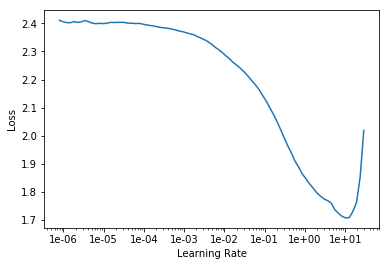

In [60]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(3,max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.217414,0.222348,0.928500,00:32
1,0.133073,0.085261,0.971500,00:32
2,0.070303,0.040906,0.987300,00:31


This is trained from scratch, of course, it's not pre-trained. We've literally created our own architecture. It's about the simplest possible architecture you can imagine. 18 seconds to train, so that's how easy it is to create a pretty accurate digit detector.

##Refactor [15:42](https://youtu.be/nWpdkZE2_cc?t=942): fastai tweaks

Let's refactor that a little. Rather than saying conv, batch norm, ReLU all the time, fast.ai already has something called **conv_layer** which **lets you create conv, batch norm, ReLU combinations**. It has various other options to do other tweaks to it, but the basic version is just exactly what I just showed you. So we can refactor that like so:

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2) 

In [0]:
model = nn.Sequential(
        conv2(1,8), #14
        conv2(8,16), #7
        conv2(16,32), #4
        conv2(32,16), #2
        conv2(16,10), #1
        Flatten() # remove (1,1) grid
      )

That's exactly the same neural net

In [0]:
learn = Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

In [68]:
learn.fit_one_cycle(10,max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.239158,0.197799,0.933500,00:31
1,0.191847,0.270177,0.915900,00:32
2,0.168726,0.144540,0.955800,00:31
3,0.130631,0.103725,0.966100,00:31
4,0.125160,0.139571,0.956200,00:32
5,0.095178,0.075221,0.977000,00:31
6,0.088830,0.050993,0.983300,00:32
7,0.065389,0.047365,0.985800,00:32
8,0.049377,0.032323,0.989900,00:31
9,0.043649,0.030366,0.989600,00:32


Let's just try a little bit longer and it's actually 99.1% accurate if we train it for all of a minute, so that's cool.

## Now using pretrained model : ResNet-ish [16:24](https://youtu.be/nWpdkZE2_cc?t=984)

How can we improve this? **What we really want to do is create a deeper network, and so a very easy way to create a deeper network would be after every stride 2 conv, add a stride 1 conv. Because the stride 1 conv doesn't change the feature map size at all, so you can add as many as you like. But there's a problem**. The problem was pointed out in this paper, very very very influential paper, called [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) by Kaiming He and colleagues at (then) Microsoft Research.

They did something interesting. They said let's look at the training error. So forget generalization even, let's just look at the training error of a network trained on CIFAR-10 and let's try one network of 20 layers just basic 3x3 convs - basically the same network I just showed you, but without batch norm. They trained a 20 layer one and a 56 layer one on the training set.

The 56 layer one has a lot more parameters. It's got a lot more of these stride 1 convs in the middle. So the one with more parameters should seriously over fit, right? **So you would expect the 56 layer one to zip down to zero-ish training error pretty quickly and that is not what happens. It is worse than the shallower network**.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/7.png?raw=true)

When you see something weird happen, really good researchers don't go "oh no, it's not working" they go "that's interesting." So Kaiming He said "that's interesting. What's going on?" and he said "I don't know, but what I do know is this - I could take this 56 layer network and make a new version of it which is identical but has to be at least as good as the 20 layer network and here's how:

![](https://github.com/hiromis/notes/blob/master/lesson7/8.png?raw=true)

When you see something weird happen, really good researchers don't go "oh no, it's not working" they go "that's interesting." So Kaiming He said "that's interesting. What's going on?" and he said "I don't know, but what I do know is this - I could take this 56 layer network and make a new version of it which is identical but has to be at least as good as the 20 layer network and here's how:

![](https://github.com/hiromis/notes/blob/master/lesson7/8.png?raw=true)

Every to convolutions, I'm going to add together the input to those two convolutions with the result of those two convolutions." In other words, he's saying instead of saying:

**Output=Conv2(Conv1(x))**

nstead, he's saying:

**Output=x+Conv2(Conv1(x))**

His theory was 56 layers worth of convolutions in that has to be at least good as the 20 layer version because it could always just set conv2 and conv1 to a bunch of 0 weights for everything except for the first 20 layers because the X (i.e. the input) could just go straight through. So this thing here is (as you see) called an **identity connection**. It's the identity function - nothing happens at all. It's also known as a **skip connection**.

So that was the theory. That's what the paper describes as the intuition behind this is what would happen if we created something which has to train at least as well as a 20 layer neural network because it kind of contains that 20 layer neural network. There's literally a path you can just skip over all the convolutions. So what happens?

What happened was he won ImageNet that year. He easily won ImageNet that year. In fact, even today, we had that record-breaking result on ImageNet speed training ourselves in the last year, we used this too. ResNet has been revolutionary.

##ResBlock Trick [20:36](https://youtu.be/nWpdkZE2_cc?t=1236)

Here's a trick if you're interested in doing some research. Anytime you find some model for anything whether it's medical image segmentation or some kind of GAN or whatever and it was written a couple of years ago, they might have forgotten to put ResBlocks in. Figure 2 is what we normally call a ResBlock. They might have forgotten to put ResBlocks in. So replace their convolutional path with a bunch of ResBlocks and you will almost always get better results faster. It's a good trick.

[Visualizing the Loss Landscape of Neural Nets](https://arxiv.org/abs/1712.09913) [21:16](https://youtu.be/nWpdkZE2_cc?t=1276)

At NeurIPS, which Rachel, I, David, and Sylvain all just came back from, we saw a new presentation where they actually figured out how to visualize the loss surface of a neural net which is really cool. This is a fantastic paper and anybody who's watching this lesson 7 is at a point where they will understand the most of the important concepts in this paper. You can read this now. You won't necessarily get all of it, but I'm sure you'll get it enough to find it interesting.

![](https://github.com/hiromis/notes/raw/master/lesson7/9.png?raw=true)

The big picture was this one. Here's what happens if you if you draw a picture where x and y here are two projections of the weight space, and z is the loss. As you move through the weight space, a 56 layer neural network without skip connections is very very bumpy. That's why this got nowhere because it just got stuck in all these hills and valleys. The exact same network with identity connections (i.e. with skip connections) has this loss landscape (on the right). So it's kind of interesting how Kaiming He recognized back in 2015 this shouldn't happen, here's a way that must fix it and it took three years before people were able to say oh this is kind of why it fixed it. It kind of reminds me of the batch norm discussion we had a couple of weeks ago that people realizing a little bit after the fact sometimes what's going on and why it helps.

In [0]:
class ResBlock(nn.Module):
    def __init__(self,nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
    
    def forward(self,x) : return x +  self.conv2(self.conv1(x))
        

In our code, we can create a ResBlock in just the way I described. We create a nn.Module, we create two conv layers (remember, a **conv_layer** is Conv2d, ReLU, batch norm), so create two of those and then in forward we go **conv1(x)**, **conv2** of that and then add **x**.

In [70]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



There's a res_block function already in fast.ai so you can just call res_block instead, and you just pass in something saying how many filters you want.

In [0]:
model = nn.Sequential(
        conv2(1,8),
        res_block(8),
        conv2(8,16),
        res_block(16),
        conv2(16,32),
        res_block(32),
        conv2(32,16),
        res_block(16),
        conv2(16,10),
        Flatten()
        )

There's the ResBlock that I defined in our notebook, and so with that ResBlock, I've just copied the previous CNN and after every conv2 except the last one, I added a res_block so this has now got three times as many layers, so it should be able to do more compute. But it shouldn't be any harder to optimize.

**Let's just refactor it one more time**. Since I go **conv2 res_block** so many times, let's just pop that into a little mini sequential model here and so I can refactor that like so:

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni,nf),res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

Keep refactoring your architectures if you're trying novel architectures because you'll make less mistakes. Very few people do this. Most research code you look at is clunky as all heck and people often make mistakes in that way, so don't do that. You're all coders, so use your coding skills to make life easier.

[24:47](https://youtu.be/nWpdkZE2_cc?t=1487)

Okay, so there's my ResNet-ish architecture. **lr_find** as usual, **fit** for a while, and I get 99.54%.

In [0]:
learn = Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


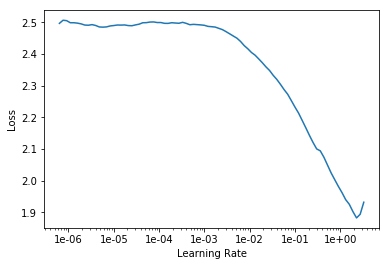

In [87]:
learn.lr_find()
learn.recorder.plot()

In [88]:
learn.fit_one_cycle(12,max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.238437,0.170562,0.951100,00:31
1,0.131322,0.110652,0.964600,00:32
2,0.105091,0.114328,0.964500,00:31
3,0.089622,0.109394,0.964200,00:31
4,0.075272,0.101326,0.969900,00:31
5,0.060685,0.070216,0.978200,00:30
6,0.049984,0.045595,0.986500,00:31
7,0.046828,0.035584,0.988800,00:31
8,0.037641,0.026890,0.991800,00:30
9,0.030043,0.016961,0.995100,00:31


## Benefit of ResNet

That's interesting because we've trained this literally from scratch with an architecture we built from scratch, I didn't look out this architecture anywhere. It's just the first thing that came to mind. But in terms of where that puts us, 0.45% error is around about the state of the art for this data set as of three or four years ago.

![](https://github.com/hiromis/notes/raw/master/lesson7/11.png?raw=true)

Today MNIST considered a trivially easy dataset, so I'm not saying like wow, we've broken some records here. People have got beyond 0.45% error, **but what I'm saying is this kind of ResNet is a genuinely extremely useful network still today**. This is really all we use in our fast ImageNet training still. And one of the reasons as well is that it's so popular so the vendors of the library spend a lot of time optimizing it, so things tend to work fast. Where else, some more modern style architectures using things like separable or group convolutions tend not to actually train very quickly in practice.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/12.png?raw=true)

If you look at the definition of **res_block** in the fast.ai code, you'll see it looks a little bit different to this, and that's because I've created something called a **MergeLayer**. A **MergeLayer** is something which in the forward (just skip dense for a moment), the forward says **x+x.orig**. So you can see there's something ResNet-ish going on here. 
- **What is x.orig?** Well, if you create a special kind of sequential model called a SequentialEx so this is like fast.ai's sequential extended. It's just like a normal sequential model, but we store the input in **x.orig**. 

So this SequentialEx, conv_layer, conv_layer, MergeLayer, will do exactly the same as ResBlock. So you can create your own variations of ResNet blocks very easily with this **SequentialEx** and **MergeLayer**.

There's something else here which is when you create your MergeLayer, you can optionally set **dense=True**, and what happens if you do? Well, if you do, it doesn't go **x+x.orig**, it goes **cat([x,x.orig])**. In other words, rather than putting a plus in this connection, it does a concatenate. **That's pretty interesting because what happens is that you have your input coming in to your Res block, and once you use concatenate instead of plus, it's not called a Res block anymore, it's called a dense block. And it's not called a ResNet anymore, it's called a DenseNet.**

The DenseNet was invented about a year after the ResNet, and if you read the DenseNet paper, it can sound incredibly complex and different, but actually it's literally identical but plus here is placed with cat. So you have your input coming into your dense block, and you've got a few convolutions in here, and then you've got some output coming out, and then you've got your identity connection, and remember it doesn't plus, it concats so the channel axis gets a little bit bigger. Then we do another dense block, and at the end of that, we have the result of the convolution as per usual, but this time the identity block is that big.

![alt text](https://github.com/hiromis/notes/blob/master/lesson7/13.png?raw=true)

So you can see that what happens is that with dense blocks it's getting bigger and bigger and bigger, and kind of interestingly the exact input is still here. So actually, no matter how deep you get the original input pixels are still there, and the original layer 1 features are still there, and the original layer 2 features are still there. So as you can imagine, **DenseNets are very memory intensive**. There are ways to manage this. From time to time, you can have a regular convolution and it squishes your channels back down, but they are memory intensive. But, they have very few parameters. **So for dealing with small datasets, you should definitely experiment with dense blocks and DenseNets. They tend to work really well on small datasets.**

Also, because it's possible to keep those original input pixels all the way down the path, they work really well for segmentation. Because for segmentation, you want to be able to reconstruct the original resolution of your picture, so having all of those original pixels still there is a super helpful.